# Audio Classification - Audio MNIST dataset

In [1]:
import shutil
from pathlib import Path
import pickle
from collections import Counter, defaultdict

from tqdm import tqdm
import wisardpkg as wp
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.io.wavfile as wav

from free_spoken_digit_dataset.utils.fsdd import FSDD
from free_spoken_digit_dataset.utils.spectogramer import dir_to_spectrogram


def load_audio_files(audio_dir):
    sample_rate_list = list()
    samples_list = list()
    names = list()
    files = [x for x in audio_dir.iterdir() if x.is_file()]
    for file in files:
        sample_rate, samples = wav.read(file)
        sample_rate_list.append(sample_rate)
        samples_list.append(samples)
        names.append(file.name)
        
    return sample_rate_list, samples_list, names


def pad_samples(samples, max_n_samples=None):
    if not max_n_samples:
        max_n_samples = np.max([len(samples_i) for samples_i in samples])
    
    padded_samples = [np.append(samples_i, [0]*(max_n_samples - len(samples_i))) 
                      if len(samples_i) < max_n_samples else samples_i[:max_n_samples]  
                      for samples_i in samples]
    return padded_samples


def plot_amplitude(samples, sample_rate, names, i):
    if isinstance(sample_rate, list):
        sample_rate_i = sample_rate[i]
    else:
        sample_rate_i = sample_rate
    
    secs = np.arange(0, len(samples[i])) / sample_rate_i
    
    fig, ax = plt.subplots(figsize=(10,5))
    _ = ax.plot(secs, samples[i])
    _ = ax.set_title(f'Sample {i} - {names[i]}')
    _ = ax.set_xlabel('Seconds')
    _ = ax.set_ylabel('Amplitude')
    plt.show()

## Loading and cleaning data

In [2]:
audio_dir = Path('free_spoken_digit_dataset/recordings/')
sample_rates, samples, names = load_audio_files(audio_dir)

Let's create the labels from the name of the recordings' files.

In [3]:
y = [int(n[:1]) for n in names]
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Now we need to separate the dataset in train and test set.

In [20]:
def split_train_and_test(samples, sample_rates, labels, file_names):
    X_train = list()
    train_sample_rates = list()
    train_file_names = list()
    y_train = list()
    X_test = list()
    test_sample_rates = list()
    test_file_names = list()
    y_test = list()
    
    for i, file_name in enumerate(file_names):
        rec_number = int(file_name.split('_')[-1].split('.')[0])
        if rec_number in [0, 1, 2, 3, 4]:
            X_test.append(samples[i])
            y_test.append(labels[i])
            test_sample_rates.append(sample_rates[i])
            test_file_names.append(file_name)
        else:
            X_train.append(samples[i])
            y_train.append(labels[i])
            train_sample_rates.append(sample_rates[i])
            train_file_names.append(file_name)
    
    return X_train, y_train, X_test, y_test, train_sample_rates, test_sample_rates, train_file_names, test_file_names

X_train, y_train, X_test, y_test,train_sample_rates, test_sample_rates,\
train_file_names, test_file_names = split_train_and_test(samples, sample_rates, y, names)

In [5]:
np.array(X_test).shape

<ipython-input-5-e5f7ff96b72b>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array(X_test).shape


(300,)

## Feature Extraction and hyperparameter optimization

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from typing import List, Union, Optional
from time import time
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ParameterGrid
from sklearn.utils.validation import check_is_fitted
from python_speech_features import mfcc
from tqdm import tqdm

np.seterr(divide='ignore')

class DatabaseZScorer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self._mean = None
        self._std = None
    
    def fit(self, x, y=None):
        x = np.concatenate(x, axis=0)
        self._mean = np.mean(x, axis=0)
        self._std = np.std(x, axis=0)
        return self
        
    def transform(self, x):
        x_transformed = list()
        for x_i in x:
            x_i = (x_i - self._mean) / self._std
            x_transformed.append(x_i)
        return x_transformed

    
def extract_features(audio_signals, sample_rates, n_filters_mfcc, window_size, 
                     window_step, append_sum=True, verbose=False):
    features = list()

    if verbose:
        iterator = tqdm(zip(audio_signals, sample_rates), desc='Extracting Features')
    else:
        iterator = zip(audio_signals, sample_rates)
    
    for audio_signal, sample_rate in iterator:
        mfccs = mfcc(audio_signal, samplerate=sample_rate, nfft=1024,
                     winlen=window_size, winstep=window_step, 
                     numcep=n_filters_mfcc, nfilt=n_filters_mfcc, 
                     winfunc=np.hamming)

        if append_sum:
            mfccs_processed = np.cumsum(mfccs, axis=0)
        else:
            mfccs_processed = mfccs

        features.append(mfccs_processed)
        
    return features


def tanh(x):
    return [np.tanh(sample) for sample in x]


def cross_validation_wisard(audio_recordings, y, sample_rates, file_names, n_splits=5, addressSize=[50], 
                            bleachingActivated=[True], n_filters_mfcc=[20], 
                            window_size=[0.05], window_step=[0.05], append_sum=[True], 
                            n_kernels=[10]):
    grid_search_results = []
    best_params = None
    best_accuracy = -1
    
    if not isinstance(y, np.ndarray):
        y = np.array(y)
    
    param_grid_dict = dict()
    param_grid_dict['addressSize'] = addressSize
    param_grid_dict['bleachingActivated'] = bleachingActivated
    param_grid_dict['n_filters_mfcc'] = n_filters_mfcc
    param_grid_dict['window_size'] = window_size
    param_grid_dict['window_step'] = window_step
    param_grid_dict['append_sum'] = append_sum
    param_grid_dict['n_kernels'] = n_kernels
    
    stratification_groups = [name.rsplit('_', 1)[0] for name in file_names] # by label and speaker
    skf = StratifiedKFold(n_splits=n_splits)
    
    param_grid = ParameterGrid(param_grid_dict)
    
    param_grid_combinations = len(list(param_grid))
    n_combs = n_splits * param_grid_combinations
    progress = tqdm(total=n_combs, position=0, leave=True)
    
    for params in param_grid:
        print(params)
        preprocessing_time = []
        training_time = []
        training_prediction_time = []
        validation_prediction_time = []
        training_accuracy = []
        validation_accuracy = []
        for train_index, val_index in skf.split(np.zeros(len(audio_recordings)), stratification_groups):
            X_train = [audio_recordings[i] for i in train_index]
            y_train = y[train_index]
            y_train_str = [str(l) for l in y_train]
            
            X_val = [audio_recordings[i] for i in val_index]
            y_val = y[val_index]
            y_val_str = [str(l) for l in y_val]
            
            # Preprocessing
            start = time()
            
            # 1) Extract MFCCs from audio recordings and use Appendsum (or not)
            X_train = extract_features(X_train, sample_rates, params['n_filters_mfcc'], params['window_size'], 
                                       params['window_step'], params['append_sum'], verbose=False)
            X_val = extract_features(X_val, sample_rates, params['n_filters_mfcc'], params['window_size'], 
                                     params['window_step'], params['append_sum'], verbose=False)
            
            # 2) Database Z-score
            z_scorer = DatabaseZScorer()
            X_train = z_scorer.fit_transform(X_train)
            X_val = z_scorer.transform(X_val)
            
            # 3) Hyperbolic tangent (scaling features to (-1, +1) interval
            X_train = tanh(X_train)
            X_val = tanh(X_val)
            
            # 4) Applying kernel canvas to each recordings' feature set
            dimension = X_train[0].shape[1]
            kernel_canvas = wp.KernelCanvas(dimension, params['n_kernels'], bitsBykernel = 16, 
                                            activationDegree = 0.075)
            
            X_train = [kernel_canvas.transform(rec_features) for rec_features in X_train]
            X_val = [kernel_canvas.transform(rec_features) for rec_features in X_val]
            
            end = time()
            preprocessing_time.append(end-start)
            
            # training
            model = wp.Wisard(params['addressSize'], bleachingActivated=params['bleachingActivated'],
                              ignoreZero=True)
            
            start = time()
            model.train(X_train, y_train_str)
            end = time()
            training_time.append(end-start)
            
            start = time()
            pred_train = model.classify(X_train)
            end = time()
            training_prediction_time.append(end-start)
            
            start = time()
            pred_val = model.classify(X_val)
            end = time()
            validation_prediction_time.append(end-start)
            
            training_accuracy.append(accuracy_score(y_train_str, pred_train))
            
            validation_accuracy.append(accuracy_score(y_val_str, pred_val))
            
            progress.update()
        
        cv_result = {'preprocessing_time_mean': np.mean(preprocessing_time),
                     'preprocessing_time_std': np.std(preprocessing_time),
                     'training_time_mean': np.mean(training_time),
                     'training_time_std': np.std(training_time),
                     'training_prediction_time_mean': np.mean(training_prediction_time),
                     'training_prediction_time_std': np.std(training_prediction_time),
                     'validation_prediction_time_mean': np.mean(validation_prediction_time),
                     'validation_prediction_time_std': np.std(validation_prediction_time),
                     'training_accuracy_mean': np.mean(training_accuracy),
                     'training_accuracy_std': np.std(training_accuracy),
                     'validation_accuracy_mean': np.mean(validation_accuracy),
                     'validation_accuracy_std': np.std(validation_accuracy)}
        
        cv_result = {**params, **cv_result}
        
        grid_search_results.append(cv_result)
        
        if (cv_result['validation_accuracy_mean'] > best_accuracy):
            best_accuracy = cv_result['validation_accuracy_mean']
            best_params = params
        
        print(f"Train acc. mean: {cv_result['training_accuracy_mean']:.4f} | Validation acc. mean: {cv_result['validation_accuracy_mean']:.4f}\n")
    
    grid_search_results = pd.DataFrame(grid_search_results)
    grid_search_results['rank'] = grid_search_results['validation_accuracy_mean'].rank(ascending=False)
    
    return grid_search_results, best_params

In [35]:
ws_gs_results, ws_best_params = cross_validation_wisard(X_train, y_train, sample_rates, train_file_names, n_splits=5, 
                                                        addressSize=[5, 10, 15, 20], bleachingActivated=[True], 
                                                        n_filters_mfcc=[10, 12, 14, 16], window_size=[0.1], window_step=[0.02], 
                                                        append_sum=[True], n_kernels=[2**10, 2**11, 2**12, 2**13])

  0%|          | 0/320 [00:00<?, ?it/s]

{'addressSize': 5, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 10, 'n_kernels': 1024, 'window_size': 0.1, 'window_step': 0.02}


  2%|▏         | 5/320 [01:25<1:29:04, 16.97s/it]

Train acc. mean: 0.9262 | Validation acc. mean: 0.7693

{'addressSize': 5, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 10, 'n_kernels': 2048, 'window_size': 0.1, 'window_step': 0.02}


  3%|▎         | 10/320 [03:31<2:01:52, 23.59s/it]

Train acc. mean: 0.9526 | Validation acc. mean: 0.8026

{'addressSize': 5, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 10, 'n_kernels': 4096, 'window_size': 0.1, 'window_step': 0.02}


  5%|▍         | 15/320 [07:30<3:45:11, 44.30s/it]

Train acc. mean: 0.9701 | Validation acc. mean: 0.8407

{'addressSize': 5, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 10, 'n_kernels': 8192, 'window_size': 0.1, 'window_step': 0.02}


  6%|▋         | 20/320 [15:24<7:02:05, 84.42s/it]

Train acc. mean: 0.9844 | Validation acc. mean: 0.8493

{'addressSize': 5, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 12, 'n_kernels': 1024, 'window_size': 0.1, 'window_step': 0.02}


  8%|▊         | 25/320 [17:17<2:38:20, 32.20s/it]

Train acc. mean: 0.9444 | Validation acc. mean: 0.7793

{'addressSize': 5, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 12, 'n_kernels': 2048, 'window_size': 0.1, 'window_step': 0.02}


  9%|▉         | 30/320 [19:38<2:19:59, 28.96s/it]

Train acc. mean: 0.9670 | Validation acc. mean: 0.8248

{'addressSize': 5, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 12, 'n_kernels': 4096, 'window_size': 0.1, 'window_step': 0.02}


 11%|█         | 35/320 [23:49<3:40:57, 46.52s/it]

Train acc. mean: 0.9846 | Validation acc. mean: 0.8559

{'addressSize': 5, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 12, 'n_kernels': 8192, 'window_size': 0.1, 'window_step': 0.02}


 12%|█▎        | 40/320 [31:42<6:29:52, 83.55s/it]

Train acc. mean: 0.9927 | Validation acc. mean: 0.8759

{'addressSize': 5, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 14, 'n_kernels': 1024, 'window_size': 0.1, 'window_step': 0.02}


 14%|█▍        | 45/320 [33:01<2:04:10, 27.09s/it]

Train acc. mean: 0.9352 | Validation acc. mean: 0.7685

{'addressSize': 5, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 14, 'n_kernels': 2048, 'window_size': 0.1, 'window_step': 0.02}


 16%|█▌        | 50/320 [35:02<1:51:27, 24.77s/it]

Train acc. mean: 0.9672 | Validation acc. mean: 0.8096

{'addressSize': 5, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 14, 'n_kernels': 4096, 'window_size': 0.1, 'window_step': 0.02}


 17%|█▋        | 55/320 [38:43<2:58:56, 40.52s/it]

Train acc. mean: 0.9874 | Validation acc. mean: 0.8544

{'addressSize': 5, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 14, 'n_kernels': 8192, 'window_size': 0.1, 'window_step': 0.02}


 19%|█▉        | 60/320 [45:50<5:38:25, 78.10s/it]

Train acc. mean: 0.9949 | Validation acc. mean: 0.8737

{'addressSize': 5, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 16, 'n_kernels': 1024, 'window_size': 0.1, 'window_step': 0.02}


 20%|██        | 65/320 [47:17<1:55:40, 27.22s/it]

Train acc. mean: 0.9292 | Validation acc. mean: 0.6956

{'addressSize': 5, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 16, 'n_kernels': 2048, 'window_size': 0.1, 'window_step': 0.02}


 22%|██▏       | 70/320 [49:22<1:45:51, 25.41s/it]

Train acc. mean: 0.9656 | Validation acc. mean: 0.7863

{'addressSize': 5, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 16, 'n_kernels': 4096, 'window_size': 0.1, 'window_step': 0.02}


 23%|██▎       | 75/320 [53:01<2:46:28, 40.77s/it]

Train acc. mean: 0.9822 | Validation acc. mean: 0.8207

{'addressSize': 5, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 16, 'n_kernels': 8192, 'window_size': 0.1, 'window_step': 0.02}


 25%|██▌       | 80/320 [1:00:18<5:17:41, 79.42s/it]

Train acc. mean: 0.9951 | Validation acc. mean: 0.8585

{'addressSize': 10, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 10, 'n_kernels': 1024, 'window_size': 0.1, 'window_step': 0.02}


 27%|██▋       | 85/320 [1:01:33<1:41:10, 25.83s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.8852

{'addressSize': 10, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 10, 'n_kernels': 2048, 'window_size': 0.1, 'window_step': 0.02}


 28%|██▊       | 90/320 [1:03:26<1:28:43, 23.15s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.8904

{'addressSize': 10, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 10, 'n_kernels': 4096, 'window_size': 0.1, 'window_step': 0.02}


 30%|██▉       | 95/320 [1:06:47<2:22:36, 38.03s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.8915

{'addressSize': 10, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 10, 'n_kernels': 8192, 'window_size': 0.1, 'window_step': 0.02}


 31%|███▏      | 100/320 [1:13:11<4:17:26, 70.21s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.8970

{'addressSize': 10, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 12, 'n_kernels': 1024, 'window_size': 0.1, 'window_step': 0.02}


 33%|███▎      | 105/320 [1:14:28<1:28:20, 24.66s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.9004

{'addressSize': 10, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 12, 'n_kernels': 2048, 'window_size': 0.1, 'window_step': 0.02}


 34%|███▍      | 110/320 [1:16:31<1:27:53, 25.11s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.9111

{'addressSize': 10, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 12, 'n_kernels': 4096, 'window_size': 0.1, 'window_step': 0.02}


 36%|███▌      | 115/320 [1:19:50<2:07:38, 37.36s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.9096

{'addressSize': 10, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 12, 'n_kernels': 8192, 'window_size': 0.1, 'window_step': 0.02}


 38%|███▊      | 120/320 [1:26:27<4:04:43, 73.42s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.9115

{'addressSize': 10, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 14, 'n_kernels': 1024, 'window_size': 0.1, 'window_step': 0.02}


 39%|███▉      | 125/320 [1:27:46<1:22:26, 25.37s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.9000

{'addressSize': 10, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 14, 'n_kernels': 2048, 'window_size': 0.1, 'window_step': 0.02}


 41%|████      | 130/320 [1:29:43<1:14:44, 23.60s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.9081

{'addressSize': 10, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 14, 'n_kernels': 4096, 'window_size': 0.1, 'window_step': 0.02}


 42%|████▏     | 135/320 [1:33:06<1:56:15, 37.71s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.9104

{'addressSize': 10, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 14, 'n_kernels': 8192, 'window_size': 0.1, 'window_step': 0.02}


 44%|████▍     | 140/320 [1:39:46<3:38:30, 72.84s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.9130

{'addressSize': 10, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 16, 'n_kernels': 1024, 'window_size': 0.1, 'window_step': 0.02}


 45%|████▌     | 145/320 [1:41:06<1:14:14, 25.45s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.8922

{'addressSize': 10, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 16, 'n_kernels': 2048, 'window_size': 0.1, 'window_step': 0.02}


 47%|████▋     | 150/320 [1:43:05<1:08:06, 24.04s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.9122

{'addressSize': 10, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 16, 'n_kernels': 4096, 'window_size': 0.1, 'window_step': 0.02}


 48%|████▊     | 155/320 [1:46:37<1:50:08, 40.05s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.9096

{'addressSize': 10, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 16, 'n_kernels': 8192, 'window_size': 0.1, 'window_step': 0.02}


 50%|█████     | 160/320 [1:53:18<3:15:41, 73.39s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.9141

{'addressSize': 15, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 10, 'n_kernels': 1024, 'window_size': 0.1, 'window_step': 0.02}


 52%|█████▏    | 165/320 [1:54:32<1:03:41, 24.65s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.8804

{'addressSize': 15, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 10, 'n_kernels': 2048, 'window_size': 0.1, 'window_step': 0.02}


 53%|█████▎    | 170/320 [1:56:34<1:03:38, 25.46s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.8819

{'addressSize': 15, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 10, 'n_kernels': 4096, 'window_size': 0.1, 'window_step': 0.02}


 55%|█████▍    | 175/320 [1:59:49<1:28:32, 36.64s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.8881

{'addressSize': 15, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 10, 'n_kernels': 8192, 'window_size': 0.1, 'window_step': 0.02}


 56%|█████▋    | 180/320 [2:06:10<2:42:52, 69.80s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.8881

{'addressSize': 15, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 12, 'n_kernels': 1024, 'window_size': 0.1, 'window_step': 0.02}


 58%|█████▊    | 185/320 [2:07:30<55:32, 24.69s/it]  

Train acc. mean: 1.0000 | Validation acc. mean: 0.8941

{'addressSize': 15, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 12, 'n_kernels': 2048, 'window_size': 0.1, 'window_step': 0.02}


 59%|█████▉    | 190/320 [2:09:26<50:31, 23.32s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.8993

{'addressSize': 15, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 12, 'n_kernels': 4096, 'window_size': 0.1, 'window_step': 0.02}


 61%|██████    | 195/320 [2:12:44<1:16:59, 36.95s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.9056

{'addressSize': 15, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 12, 'n_kernels': 8192, 'window_size': 0.1, 'window_step': 0.02}


 62%|██████▎   | 200/320 [2:19:15<2:22:25, 71.22s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.9089

{'addressSize': 15, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 14, 'n_kernels': 1024, 'window_size': 0.1, 'window_step': 0.02}


 64%|██████▍   | 205/320 [2:20:47<49:57, 26.07s/it]  

Train acc. mean: 1.0000 | Validation acc. mean: 0.8874

{'addressSize': 15, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 14, 'n_kernels': 2048, 'window_size': 0.1, 'window_step': 0.02}


 66%|██████▌   | 210/320 [2:22:43<43:31, 23.74s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.9067

{'addressSize': 15, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 14, 'n_kernels': 4096, 'window_size': 0.1, 'window_step': 0.02}


 67%|██████▋   | 215/320 [2:26:06<1:06:26, 37.97s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.9115

{'addressSize': 15, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 14, 'n_kernels': 8192, 'window_size': 0.1, 'window_step': 0.02}


 69%|██████▉   | 220/320 [2:32:44<1:59:40, 71.81s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.9115

{'addressSize': 15, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 16, 'n_kernels': 1024, 'window_size': 0.1, 'window_step': 0.02}


 70%|███████   | 225/320 [2:34:03<39:55, 25.21s/it]  

Train acc. mean: 1.0000 | Validation acc. mean: 0.8730

{'addressSize': 15, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 16, 'n_kernels': 2048, 'window_size': 0.1, 'window_step': 0.02}


 72%|███████▏  | 230/320 [2:36:04<36:29, 24.33s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.8919

{'addressSize': 15, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 16, 'n_kernels': 4096, 'window_size': 0.1, 'window_step': 0.02}


 73%|███████▎  | 235/320 [2:39:34<54:33, 38.51s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.9037

{'addressSize': 15, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 16, 'n_kernels': 8192, 'window_size': 0.1, 'window_step': 0.02}


 75%|███████▌  | 240/320 [2:46:15<1:38:26, 73.84s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.9089

{'addressSize': 20, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 10, 'n_kernels': 1024, 'window_size': 0.1, 'window_step': 0.02}


 77%|███████▋  | 245/320 [2:47:35<31:31, 25.22s/it]  

Train acc. mean: 1.0000 | Validation acc. mean: 0.8626

{'addressSize': 20, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 10, 'n_kernels': 2048, 'window_size': 0.1, 'window_step': 0.02}


 78%|███████▊  | 250/320 [2:49:27<26:39, 22.85s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.8700

{'addressSize': 20, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 10, 'n_kernels': 4096, 'window_size': 0.1, 'window_step': 0.02}


 80%|███████▉  | 255/320 [2:52:40<38:57, 35.96s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.8830

{'addressSize': 20, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 10, 'n_kernels': 8192, 'window_size': 0.1, 'window_step': 0.02}


 81%|████████▏ | 260/320 [2:59:04<1:09:47, 69.80s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.8867

{'addressSize': 20, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 12, 'n_kernels': 1024, 'window_size': 0.1, 'window_step': 0.02}


 83%|████████▎ | 265/320 [3:00:21<22:24, 24.44s/it]  

Train acc. mean: 1.0000 | Validation acc. mean: 0.8693

{'addressSize': 20, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 12, 'n_kernels': 2048, 'window_size': 0.1, 'window_step': 0.02}


 84%|████████▍ | 270/320 [3:02:15<19:15, 23.11s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.8804

{'addressSize': 20, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 12, 'n_kernels': 4096, 'window_size': 0.1, 'window_step': 0.02}


 86%|████████▌ | 275/320 [3:05:33<27:42, 36.95s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.8933

{'addressSize': 20, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 12, 'n_kernels': 8192, 'window_size': 0.1, 'window_step': 0.02}


 88%|████████▊ | 280/320 [3:12:00<46:46, 70.17s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.9015

{'addressSize': 20, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 14, 'n_kernels': 1024, 'window_size': 0.1, 'window_step': 0.02}


 89%|████████▉ | 285/320 [3:13:18<14:23, 24.68s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.8485

{'addressSize': 20, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 14, 'n_kernels': 2048, 'window_size': 0.1, 'window_step': 0.02}


 91%|█████████ | 290/320 [3:15:14<11:45, 23.53s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.8878

{'addressSize': 20, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 14, 'n_kernels': 4096, 'window_size': 0.1, 'window_step': 0.02}


 92%|█████████▏| 295/320 [3:18:40<15:49, 38.00s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.8952

{'addressSize': 20, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 14, 'n_kernels': 8192, 'window_size': 0.1, 'window_step': 0.02}


 94%|█████████▍| 300/320 [3:25:07<23:35, 70.76s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.9067

{'addressSize': 20, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 16, 'n_kernels': 1024, 'window_size': 0.1, 'window_step': 0.02}


 95%|█████████▌| 305/320 [3:26:36<06:49, 27.32s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.7985

{'addressSize': 20, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 16, 'n_kernels': 2048, 'window_size': 0.1, 'window_step': 0.02}


 97%|█████████▋| 310/320 [3:28:33<04:00, 24.00s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.8515

{'addressSize': 20, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 16, 'n_kernels': 4096, 'window_size': 0.1, 'window_step': 0.02}


 98%|█████████▊| 315/320 [3:31:57<03:10, 38.05s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.8774

{'addressSize': 20, 'append_sum': True, 'bleachingActivated': True, 'n_filters_mfcc': 16, 'n_kernels': 8192, 'window_size': 0.1, 'window_step': 0.02}


100%|██████████| 320/320 [3:38:35<00:00, 72.91s/it]

Train acc. mean: 1.0000 | Validation acc. mean: 0.8907



In [6]:
ws_gs_results = ws_gs_results.sort_values('rank').reset_index(drop=True)

with open('results/wisard2_gs_results.pickle', 'wb') as file:
    pickle.dump(ws_gs_results, file)

ws_gs_results.to_csv('results/wisard2_gs_results.csv', sep=';')

ws_gs_results

,addressSize,append_sum,bleachingActivated,n_filters_mfcc,n_kernels,window_size,window_step,preprocessing_time_mean,preprocessing_time_std,training_time_mean,training_time_std,training_prediction_time_mean,training_prediction_time_std,validation_prediction_time_mean,validation_prediction_time_std,training_accuracy_mean,training_accuracy_std,validation_accuracy_mean,validation_accuracy_std,rank
0,10,True,True,16,8192,0.1,0.02,68.779536,0.461718,1.947594,0.046322,7.282843,0.064355,1.763058,0.011880,1.000000,0.000000,0.914074,0.025272,1.0
1,10,True,True,14,8192,0.1,0.02,68.809825,2.102739,2.021882,0.132910,7.123245,0.131645,1.704458,0.026431,1.000000,0.000000,0.912963,0.009443,2.0
2,10,True,True,16,2048,0.1,0.02,21.257074,0.148606,0.390748,0.010244,1.612594,0.060409,0.457569,0.041106,1.000000,0.000000,0.912222,0.022999,3.0
3,10,True,True,12,8192,0.1,0.02,67.674637,1.687225,2.156996,0.451407,7.586651,1.009147,1.688890,0.027610,1.000000,0.000000,0.911481,0.009544,4.0
4,15,True,True,14,8192,0.1,0.02,69.580245,3.124243,1.803700,0.085118,6.189355,0.109496,1.501977,0.040649,1.000000,0.000000,0.911481,0.016580,5.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,5,True,True,16,2048,0.1,0.02,21.195311,0.260166,0.380976,0.035190,2.672261,0.162582,0.684966,0.069627,0.965556,0.003135,0.786296,0.024612,60.0
60,5,True,True,12,1024,0.1,0.02,20.212808,2.871695,0.213629,0.031466,1.580484,0.401744,0.400684,0.126144,0.944444,0.005834,0.779259,0.018310,61.0
61,5,True,True,10,1024,0.1,0.02,15.484381,1.137779,0.166962,0.023644,1.181425,0.172768,0.308179,0.040861,0.926204,0.007463,0.769259,0.023733,62.0
62,5,True,True,14,1024,0.1,0.02,14.111317,0.126468,0.158926,0.001679,1.118401,0.016352,0.290834,0.010492,0.935185,0.009676,0.768519,0.015135,63.0


In [5]:
with open('results/wisard2_gs_best_params.pickle', 'wb') as file:
    pickle.dump(ws_best_params, file)

ws_best_params

{'addressSize': 10,
 'append_sum': True,
 'bleachingActivated': True,
 'n_filters_mfcc': 16,
 'n_kernels': 8192,
 'window_size': 0.1,
 'window_step': 0.02}

In [4]:
with open('results/wisard2_gs_best_params.pickle', 'rb') as file:
    ws_best_params = pickle.load(file)

In [39]:
# Preprocessing
y_train_str = [str(l) for l in y_train]
y_test_str = [str(l) for l in y_test]

# 1) Extract MFCCs from audio recordings and use Appendsum (or not)
X_train_preprocessed = extract_features(X_train, sample_rates, ws_best_params['n_filters_mfcc'], ws_best_params['window_size'], 
                                        ws_best_params['window_step'], ws_best_params['append_sum'], verbose=False)
X_test_preprocessed = extract_features(X_test, sample_rates, ws_best_params['n_filters_mfcc'], ws_best_params['window_size'], 
                                       ws_best_params['window_step'], ws_best_params['append_sum'], verbose=False)

# 2) Database Z-score
z_scorer = DatabaseZScorer()
X_train_preprocessed = z_scorer.fit_transform(X_train_preprocessed)
X_test_preprocessed = z_scorer.transform(X_test_preprocessed)

# 3) Hyperbolic tangent (scaling features to (-1, +1) interval
X_train_preprocessed = tanh(X_train_preprocessed)
X_test_preprocessed = tanh(X_test_preprocessed)

# 4) Applying kernel canvas to each recordings' feature set
dimension = X_train_preprocessed[0].shape[1]
kernel_canvas = wp.KernelCanvas(dimension, ws_best_params['n_kernels'], 
                                bitsBykernel = 16, activationDegree = 0.075)

X_train_preprocessed = [kernel_canvas.transform(rec_features) for rec_features in X_train_preprocessed]
X_test_preprocessed = [kernel_canvas.transform(rec_features) for rec_features in X_test_preprocessed]

# training
model = wp.Wisard(ws_best_params['addressSize'], 
                  bleachingActivated=ws_best_params['bleachingActivated'],
                  ignoreZero=True)

model.train(X_train_preprocessed, y_train_str)

pred_train = model.classify(X_train_preprocessed)
pred_test = model.classify(X_test_preprocessed)

training_accuracy = accuracy_score(y_train_str, pred_train)
test_accuracy = accuracy_score(y_test_str, pred_test)

print(f'Training Accuracy: {training_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Training Accuracy: 1.0000
Test Accuracy: 0.9467


## Results visualization

In [9]:
ws_gs_results = pd.read_csv('results/wisard2_gs_results.csv', sep=';')

ws_gs_results

,Unnamed: 0,addressSize,append_sum,bleachingActivated,n_filters_mfcc,n_kernels,window_size,window_step,preprocessing_time_mean,preprocessing_time_std,...,training_time_std,training_prediction_time_mean,training_prediction_time_std,validation_prediction_time_mean,validation_prediction_time_std,training_accuracy_mean,training_accuracy_std,validation_accuracy_mean,validation_accuracy_std,rank
0,0,10,True,True,16,8192,0.1,0.02,68.779536,0.461718,...,0.046322,7.282843,0.064355,1.763058,0.011880,1.000000,0.000000,0.914074,0.025272,1.0
1,1,10,True,True,14,8192,0.1,0.02,68.809825,2.102739,...,0.132910,7.123245,0.131645,1.704458,0.026431,1.000000,0.000000,0.912963,0.009443,2.0
2,2,10,True,True,16,2048,0.1,0.02,21.257074,0.148606,...,0.010244,1.612594,0.060409,0.457569,0.041106,1.000000,0.000000,0.912222,0.022999,3.0
3,3,10,True,True,12,8192,0.1,0.02,67.674637,1.687225,...,0.451407,7.586651,1.009147,1.688890,0.027610,1.000000,0.000000,0.911481,0.009544,4.0
4,4,15,True,True,14,8192,0.1,0.02,69.580245,3.124243,...,0.085118,6.189355,0.109496,1.501977,0.040649,1.000000,0.000000,0.911481,0.016580,5.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,59,5,True,True,16,2048,0.1,0.02,21.195311,0.260166,...,0.035190,2.672261,0.162582,0.684966,0.069627,0.965556,0.003135,0.786296,0.024612,60.0
60,60,5,True,True,12,1024,0.1,0.02,20.212808,2.871695,...,0.031466,1.580484,0.401744,0.400684,0.126144,0.944444,0.005834,0.779259,0.018310,61.0
61,61,5,True,True,10,1024,0.1,0.02,15.484381,1.137779,...,0.023644,1.181425,0.172768,0.308179,0.040861,0.926204,0.007463,0.769259,0.023733,62.0
62,62,5,True,True,14,1024,0.1,0.02,14.111317,0.126468,...,0.001679,1.118401,0.016352,0.290834,0.010492,0.935185,0.009676,0.768519,0.015135,63.0


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

### Hyperparameters influence on accuracy

Text(0.5, 1.0, '5-folds stratified CV results')

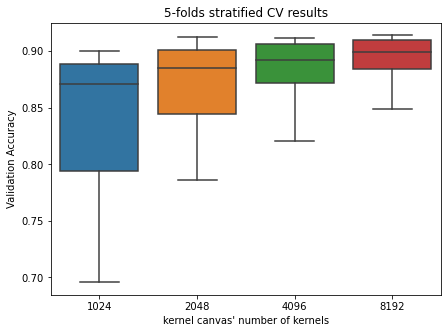

In [50]:
fig, ax = plt.subplots(figsize=(7,5))
ax = sns.boxplot(x="n_kernels", y="validation_accuracy_mean", data=ws_gs_results, ax=ax)
ax.set_ylabel('Validation Accuracy')
ax.set_xlabel("kernel canvas' number of kernels")
ax.set_title('5-folds stratified CV results')

Text(0.5, 1.0, '5-folds stratified CV results')

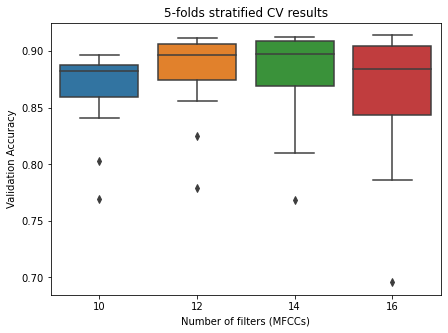

In [12]:
fig, ax = plt.subplots(figsize=(7,5))
ax = sns.boxplot(x="n_filters_mfcc", y="validation_accuracy_mean", data=ws_gs_results, ax=ax)
ax.set_ylabel('Validation Accuracy')
ax.set_xlabel("Number of filters (MFCCs)")
ax.set_title('5-folds stratified CV results')

Text(0.5, 1.0, '5-folds stratified CV results')

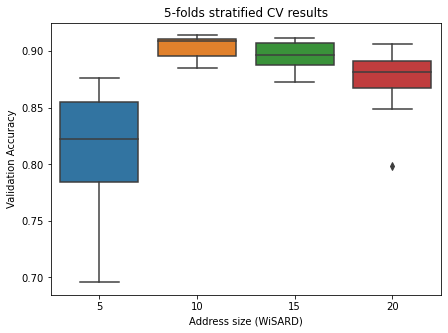

In [13]:
fig, ax = plt.subplots(figsize=(7,5))
ax = sns.boxplot(x="addressSize", y="validation_accuracy_mean", data=ws_gs_results, ax=ax)
ax.set_ylabel('Validation Accuracy')
ax.set_xlabel("Address size (WiSARD)")
ax.set_title('5-folds stratified CV results')

### Hyperparameters influence on time

Text(0.5, 1.0, 'Time comparison')

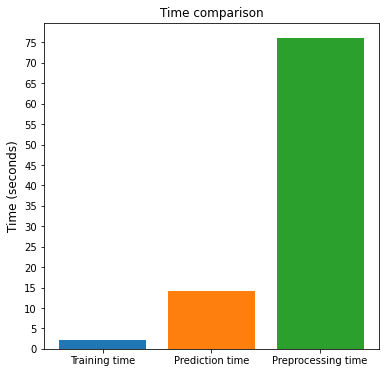

In [53]:
timing_comparison = ws_gs_results[['training_time_mean', 'training_prediction_time_mean', 'preprocessing_time_mean']].stack()

sns.set_style()
fig, ax = plt.subplots(figsize=(6,6))
#ax = sns.barplot(x=timing_comparison.index, y=timing_comparison.values, label="Training time", ax=ax)
ax.bar(x='Training time', height=ws_gs_results['training_time_mean'])
ax.bar(x='Prediction time', height=ws_gs_results['training_prediction_time_mean'])
ax.bar(x='Preprocessing time', height=ws_gs_results['preprocessing_time_mean'])
ax.set_ylabel('Time (seconds)', fontsize=12)
ax.set_yticks(np.arange(0,80,5))
ax.set_title('Time comparison')

Text(0.5, 1.0, 'Training time comparison')

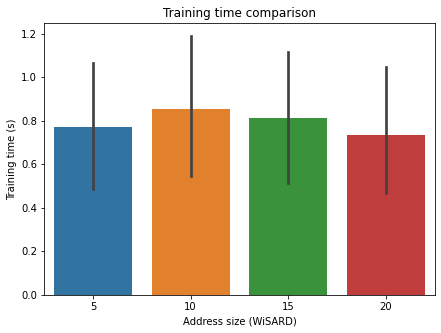

In [52]:
fig, ax = plt.subplots(figsize=(7,5))
ax = sns.barplot(x="addressSize", y="training_time_mean", data=ws_gs_results, ax=ax)
ax.set_ylabel('Training time (s)')
ax.set_xlabel("Address size (WiSARD)")
ax.set_title('Training time comparison')

Text(0.5, 1.0, 'Training time comparison')

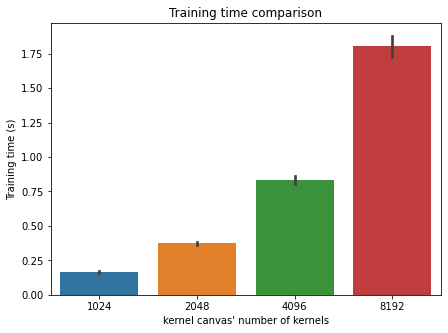

In [50]:
fig, ax = plt.subplots(figsize=(7,5))
ax = sns.barplot(x="n_kernels", y="training_time_mean", data=ws_gs_results, ax=ax)
ax.set_ylabel('Training time (s)')
ax.set_xlabel("kernel canvas' number of kernels")
ax.set_title('Training time comparison')

Text(0.5, 1.0, 'Preprocessing time comparison')

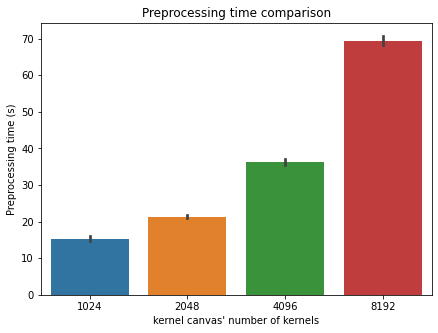

In [51]:
fig, ax = plt.subplots(figsize=(7,5))
ax = sns.barplot(x="n_kernels", y="preprocessing_time_mean", data=ws_gs_results, ax=ax)
ax.set_ylabel('Preprocessing time (s)')
ax.set_xlabel("kernel canvas' number of kernels")
ax.set_title('Preprocessing time comparison')

Text(0.5, 1.0, 'Preprocessing time comparison')

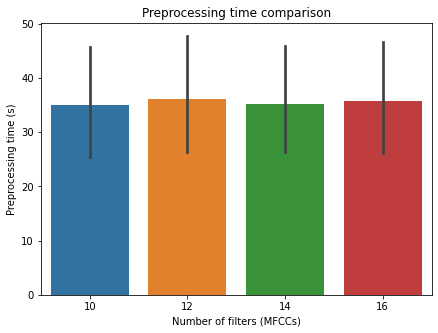

In [55]:
fig, ax = plt.subplots(figsize=(7,5))
ax = sns.barplot(x="n_filters_mfcc", y="preprocessing_time_mean", data=ws_gs_results, ax=ax)
ax.set_ylabel('Preprocessing time (s)')
ax.set_xlabel("Number of filters (MFCCs)")
ax.set_title('Preprocessing time comparison')